Loading erato-forewings-color_3 Data
Length of input data: 484
Length of train data: 48


Shapley Value Sampling attribution:   0%|          | 0/201 [00:00<?, ?it/s]

/home/carlyn.1/miniconda3/envs/dna/lib/python3.11/site-packages/torch/nn/modules/conv.py:456: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /opt/conda/conda-bld/pytorch_1699449201450/work/aten/src/ATen/native/Convolution.cpp:1008.)
  return F.conv2d(input, weight, bias, self.stride,


Shapley Value Sampling attribution:   0%|          | 0/201 [00:00<?, ?it/s]

Shapley Value Sampling attribution:   0%|          | 0/201 [00:00<?, ?it/s]

Shapley Value Sampling attribution:   0%|          | 0/201 [00:00<?, ?it/s]

Shapley Value Sampling attribution:   0%|          | 0/201 [00:00<?, ?it/s]

Shapley Value Sampling attribution:   0%|          | 0/201 [00:00<?, ?it/s]

Shapley Value Sampling attribution:   0%|          | 0/201 [00:00<?, ?it/s]

Shapley Value Sampling attribution:   0%|          | 0/201 [00:00<?, ?it/s]

Shapley Value Sampling attribution:   0%|          | 0/201 [00:00<?, ?it/s]

Shapley Value Sampling attribution:   0%|          | 0/201 [00:00<?, ?it/s]

Shapley Value Sampling attribution:   0%|          | 0/201 [00:00<?, ?it/s]

Shapley Value Sampling attribution:   0%|          | 0/201 [00:00<?, ?it/s]

/tmp/ipykernel_2765389/2791377428.py:139: RuntimeWarning: invalid value encountered in divide
  test_att /= test_att.max()


Length of input data: 484
Length of train data: 48


Shapley Value Sampling attribution:   0%|          | 0/201 [00:00<?, ?it/s]

Shapley Value Sampling attribution:   0%|          | 0/201 [00:00<?, ?it/s]

Shapley Value Sampling attribution:   0%|          | 0/201 [00:00<?, ?it/s]

Shapley Value Sampling attribution:   0%|          | 0/201 [00:00<?, ?it/s]

Shapley Value Sampling attribution:   0%|          | 0/201 [00:00<?, ?it/s]

Shapley Value Sampling attribution:   0%|          | 0/201 [00:00<?, ?it/s]

Shapley Value Sampling attribution:   0%|          | 0/201 [00:00<?, ?it/s]

Shapley Value Sampling attribution:   0%|          | 0/201 [00:00<?, ?it/s]

Shapley Value Sampling attribution:   0%|          | 0/201 [00:00<?, ?it/s]

Shapley Value Sampling attribution:   0%|          | 0/201 [00:00<?, ?it/s]

Shapley Value Sampling attribution:   0%|          | 0/201 [00:00<?, ?it/s]

Shapley Value Sampling attribution:   0%|          | 0/201 [00:00<?, ?it/s]

Length of input data: 484
Length of train data: 48


Shapley Value Sampling attribution:   0%|          | 0/201 [00:00<?, ?it/s]

Shapley Value Sampling attribution:   0%|          | 0/201 [00:00<?, ?it/s]

Shapley Value Sampling attribution:   0%|          | 0/201 [00:00<?, ?it/s]

Shapley Value Sampling attribution:   0%|          | 0/201 [00:00<?, ?it/s]

Shapley Value Sampling attribution:   0%|          | 0/201 [00:00<?, ?it/s]

Shapley Value Sampling attribution:   0%|          | 0/201 [00:00<?, ?it/s]

Shapley Value Sampling attribution:   0%|          | 0/201 [00:00<?, ?it/s]

Shapley Value Sampling attribution:   0%|          | 0/201 [00:00<?, ?it/s]

Shapley Value Sampling attribution:   0%|          | 0/201 [00:00<?, ?it/s]

Shapley Value Sampling attribution:   0%|          | 0/201 [00:00<?, ?it/s]

Shapley Value Sampling attribution:   0%|          | 0/201 [00:00<?, ?it/s]

Shapley Value Sampling attribution:   0%|          | 0/201 [00:00<?, ?it/s]

Length of input data: 484
Length of train data: 48


Shapley Value Sampling attribution:   0%|          | 0/201 [00:00<?, ?it/s]

Shapley Value Sampling attribution:   0%|          | 0/201 [00:00<?, ?it/s]

Shapley Value Sampling attribution:   0%|          | 0/201 [00:00<?, ?it/s]

Shapley Value Sampling attribution:   0%|          | 0/201 [00:00<?, ?it/s]

Shapley Value Sampling attribution:   0%|          | 0/201 [00:00<?, ?it/s]

Shapley Value Sampling attribution:   0%|          | 0/201 [00:00<?, ?it/s]

Shapley Value Sampling attribution:   0%|          | 0/201 [00:00<?, ?it/s]

Shapley Value Sampling attribution:   0%|          | 0/201 [00:00<?, ?it/s]

Shapley Value Sampling attribution:   0%|          | 0/201 [00:00<?, ?it/s]

Shapley Value Sampling attribution:   0%|          | 0/201 [00:00<?, ?it/s]

Shapley Value Sampling attribution:   0%|          | 0/201 [00:00<?, ?it/s]

Shapley Value Sampling attribution:   0%|          | 0/201 [00:00<?, ?it/s]

Plotting erato-forewings-color_3 Data
nan nan


ValueError: alpha must be between 0 and 1, inclusive, but min is nan, max is nan

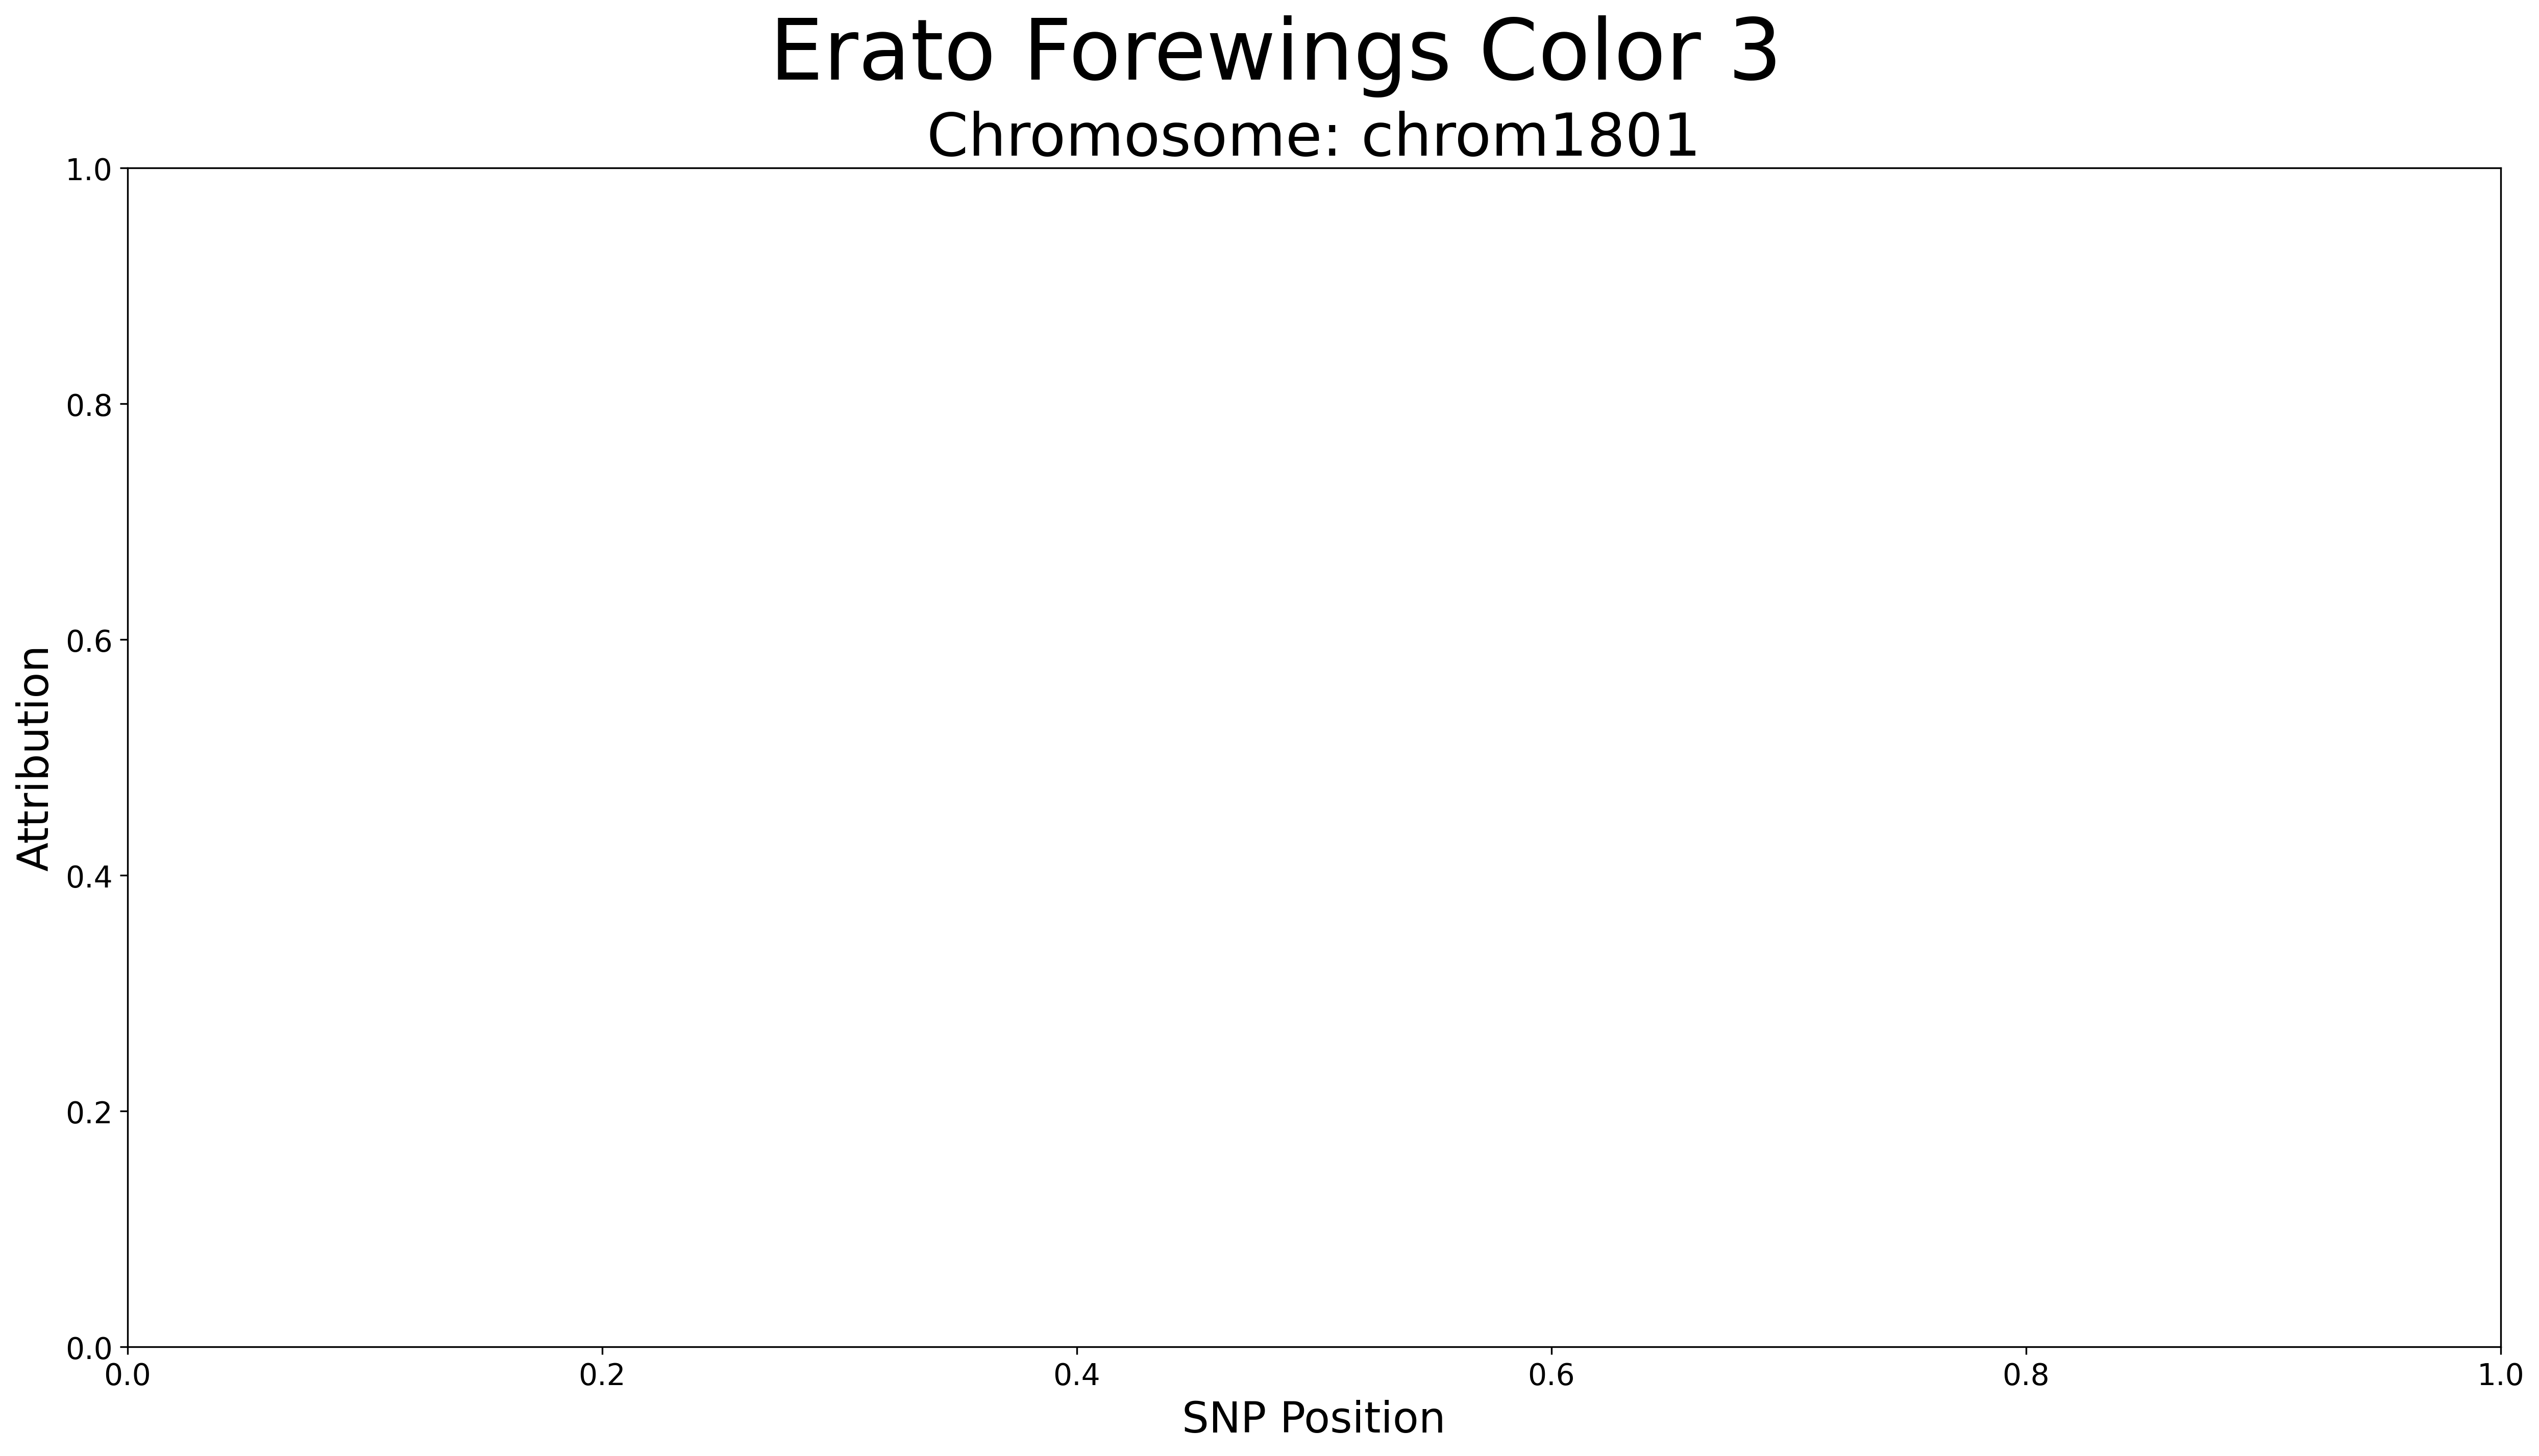

In [1]:
import os
import sys
sys.path.append("../")

from pathlib import Path

import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import splrep, splev, interp1d
from tqdm import tqdm

from torch.utils.data import DataLoader

from gtp.evaluation import get_guided_gradcam_attr, get_saliency_attr, get_guided_gradcam_attr_test, get_shapley_sampling_attr
from gtp.experiments import get_all_large_genes, get_experiment, get_root_paths
from gtp.data_tools import parse_patternize_csv, load_json, VCF_Dataset
from gtp.models.net import SoyBeanNet

#ROOT = Path("/home","carlyn.1","dna-trait-analysis","results","chromosome_out_2")
ROOT = Path("/home","carlyn.1","dna-trait-analysis","results","chromosome")
SPECIES = ["erato"]
#SPECIES = ["erato", "melpomene"]
WINGS = ["forewings"]
#WINGS = ["forewings", "hindwings"]
#COLORS = ["color_1", "color_2", "color_3", "total"]
COLORS = ["color_3"]
DATA_FOLDER = Path("melpomene_Hmel218003o_forewings_color_3")
REDO_ATTRIBUTION = True
OUT_DIMS = [0]
MODEL_OUT_DIMS = 1

PLT_COLORS = ["#767c6f", "#373021", "#bb2f28", "green"]

def load_data(datafile, experiment, batch_size=32):
    pca_data = parse_patternize_csv(experiment.pca_loading_path)
    input_data = np.load(experiment.gene_vcf_path)['arr_0']
    metadata = load_json(experiment.metadata_path)
    
    cam_ids = []
    with open(datafile, 'r') as f:
        lines = f.readlines()
        for line in lines:
            new_ids = line.split(",")
            new_ids[-1] = new_ids[-1].strip()
            cam_ids.extend(new_ids)
    
    test_data = []
    print(f"Length of input data: {len(input_data)}")
    for name, row in zip(metadata, input_data):
        if name+"_d" in pca_data and name in cam_ids:
            test_data.append([name, row, pca_data[name+"_d"]])
    print(f"Length of train data: {len(test_data)}")
    
    test_dataset = VCF_Dataset(test_data)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, num_workers=8, shuffle=False)
    
    return test_dataloader, test_data[0][1].shape[0]

def load_model(model_path, d_dim, out_dims=2):
    model = SoyBeanNet(window_size=d_dim, 
                       num_out_dims=out_dims, 
                       insize=3, 
                       hidden_dim=10, 
                       drop_out_prob=0.75).cuda()
    weights = torch.load(model_path)
    model.load_state_dict(weights)
    return model

def get_chromo_info(path, index):
    with open(path, 'r') as f:
        line = f.readlines()[index]
        line = line.strip()
        cols = line.split("\t")
        chromo, pos, ref_alle, alt_alle = cols[:4]
        return chromo, pos, ref_alle, alt_alle

def get_chromosome_positions(species, gene, wing, color):
    vcf_root, _ = get_root_paths()
    chrom_path = Path(vcf_root) / Path(f"{species}/chrom/" + gene + ".tsv")
    with open(chrom_path, 'r') as f:
        positions = [int(line.strip().split("\t")[1]) for line in f.readlines()]

    return positions

def format_title(species, wing, color):
    color_txt = ' '.join(color.capitalize().split("_"))
    return f"{species.capitalize()} {wing.capitalize()} {color_txt}"
    
large_genes = get_all_large_genes()
for species in SPECIES:
    for wing in WINGS:
        for c, color in enumerate(COLORS):
            scaled_data = []
            rmse_data = None
            print(f"Loading {species}-{wing}-{color} Data")
            for i, gene in enumerate(large_genes[species]):
                exp_name = "_".join([species, gene, wing, color])
                data_folder = ROOT / Path(exp_name)
                with open(data_folder / "out.log", 'r') as f:
                    lines = f.readlines()
                    parts = lines[-3].strip().split(" ")
                    train_rmse = float(parts[2])
                    val_rmse = float(parts[6])
                    test_rmse = float(parts[10])
                    rmse = np.array([[train_rmse, val_rmse, test_rmse]])
                    if i == 0:
                        rmse_data = rmse
                    else:
                        rmse_data = np.concatenate((rmse_data, rmse), axis=0)
                    
                if not REDO_ATTRIBUTION:
                    data_path = data_folder / "att_points.npz"
                    test_att = np.load(data_path)["test"]
                else:
                    model_path = data_folder / "model.pt"
                    test_datafile = data_folder / "test_split.txt"
                    experiment = get_experiment(species, gene, wing, color, is_large=True)
                    dloader, d_dim = load_data(test_datafile, experiment, batch_size=4)
                    torch.cuda.set_device(2)
                    model = load_model(model_path, d_dim, out_dims=MODEL_OUT_DIMS)
                    model.eval()
                    test_att = None
                    for out_tgt in OUT_DIMS:
                        if True:
                            #att = get_shapley_sampling_attr(model, dloader, target=out_tgt, n_samples=200, n_windows=10)
                            att = get_saliency_attr(model, dloader, target=out_tgt)
                        else:
                            #att = get_guided_gradcam_attr(model, dloader, target=out_tgt)
                            att = get_guided_gradcam_attr_test(model, dloader, target=out_tgt)
                        if test_att is None:
                            test_att = att
                        else:
                            test_att += att
                        
                    
                test_att = np.abs(test_att)
                test_att -= test_att.min()
                test_att /= test_att.max()
                scaled_data.append(test_att)

            
            # Scale the data
            idx = 1 # Scaling based on the validation RMSE
            gene_scale = rmse_data[:, idx] / rmse_data[:, idx].sum() # We normalize this way, as the highest RMSE should not get zeros in the end
            gene_scale = 1 - gene_scale # We flip as we want lower RMSE to have higher contribution
            #gene_scale = [1]
            #assert len(gene_scale) == 4, "There should only be 4 for the 4 genes."            

            print(f"Plotting {species}-{wing}-{color} Data")
            fig, axs = plt.subplots(4, 1, figsize=(20, 40), dpi=300)
            #fig_title = f"{species} - {wing} - {color}"
            fig_title = format_title(species, wing, color)
            fig.suptitle(fig_title, fontsize=40)
            FONT_SIZE = 18
            plt.rc('font', size=FONT_SIZE)            # fontsize of the text sizes
            plt.rc('legend', fontsize=FONT_SIZE)  # fontsize of the legend
            plt.rc('axes', labelsize='medium', titlesize='large')
            for i, gene in enumerate(large_genes[species]):
                chromosome_positions = get_chromosome_positions(species, gene, wing, color)
                
                TMP = True
                if TMP:
                    fig, ax = plt.subplots(1, 1, figsize=(20, 10), dpi=300)
                    #fig_title = f"{species} - {wing} - {color}"
                    fig_title = format_title(species, wing, color)
                    fig.suptitle(fig_title, fontsize=40)
                else:
                    ax = axs[i]
                
                test_att = scaled_data[i]
                # Scale
                test_att *= gene_scale[i]
                
                ax.set_ylabel('Attribution', fontsize=20)
                ax.set_xlabel('SNP Position', fontsize=20)
                ax.tick_params(axis='both', labelsize=14)
                #ax.set_title(f"Chromosome: {gene} - RMSE: {round(rmse_data[i, idx], 4)}")
                ax.set_title(f"Chromosome: {gene}", fontsize=28)

                x_type = "chromosome"
                if x_type == "chromosome":
                    #x_max = max(chromosome_positions)
                    X = np.array(chromosome_positions)
                else:
                    x_max = test_att.shape[0]
                    X = np.arange(x_max)

                y = test_att
                ys = (y - y.min())/(y.max()-y.min())
                alpha = 0.2 + ys * 0.8
                print(y.max(), y.min())
                s = ys * 20

                ax.scatter(X, y, alpha=alpha, s=s, color=PLT_COLORS[c])
                SMOOTH = False
                SMOOTH_ALPHA = 0.50
                if SMOOTH:
                    smooth_y = []
                    for i, (orgx, orgy) in enumerate(zip(X, y)):
                        if i == 0:
                            smooth_y.append(orgy)
                            continue
                        
                        newy = SMOOTH_ALPHA * orgy + (1-SMOOTH_ALPHA) * smooth_y[-1]
                        smooth_y.append(newy)
                        
                    #spline_fn = splrep(chromosome_positions, y)
                    #spline_fn = interp1d(chromosome_positions, y, kind="cubic")
                    #spline_X = np.linspace(min(chromosome_positions), max(chromosome_positions), 50)
                    #spline_Y = spline_fn(spline_X)
                    #spline_Y = splev(spline_X, spline_fn)
                    #spline_Y = spline_fn(spline_X)
                    #ax.plot(spline_X, spline_Y, color="brown", alpha=0.5, linewidth=3)
                    ax.plot(X, smooth_y, color="brown", alpha=0.5, linewidth=3)
                #ax.bar(X[prev:prev+gd.size], test_att[prev:prev+gd.size], align='center', alpha=0.1, s=0.1, color=colors[i], label=gd.gene)
                #prev += gd.size
                #handles.append(mpatches.Patch(color=colors[i], label=gd.gene))

                #ax.set_ylim([0, 1.1])
                #ax.legend(handles=handles)
                # On the higher end, takes about 16s
                
                # Get max position
                max_positions = np.argsort(y)[-5:][::-1]
                #max_positions = []
                prev_plots = []
                
                def too_close(new_pos):
                    for p in prev_plots:
                        diff = abs(new_pos - p)
                        if  diff < 10_000: return True
                    return False
                
                for max_i in max_positions:
                    if too_close(max_i): continue # Don't plot too close
                    prev_plots.append(max_i)
                    chromo_pos = chromosome_positions[max_i]
                    ax.annotate(chromo_pos,
                                xy=(X[max_i], y[max_i]),
                                xycoords="data",
                                xytext=(X[max_i], y[max_i]),
                                arrowprops=dict(facecolor=PLT_COLORS[c], shrink=0.05),
                                horizontalalignment='center',
                                verticalalignment='bottom')

                with open(f"chrom_{gene}_{fig_title}.csv", 'w') as f:
                    f.write("Chromosome Position,Attribution\n")
                    for pos, att in zip(chromosome_positions, y):
                        f.write(f"{pos},{att}\n")
                        
                if TMP:
                    fig.tight_layout()
                    fig.subplots_adjust(top=0.85) # Adjusts the figure title so it isn't cramped into the subplot titles
                    plt.savefig(f"chrom_{fig_title}_{gene}.png")
            fig.tight_layout()
            fig.subplots_adjust(top=0.95) # Adjusts the figure title so it isn't cramped into the subplot titles
            plt.savefig(f"chrom_{fig_title}.png")
            
            
# To plot all figures, it takes: 10 - 15min
# To plot one figure, for one row: 48 seconds
